In [8]:
using Plots
using LaTeXStrings
using DifferentialEquations
using LinearAlgebra
using PrettyTables

### 1. Introduction
We first introduce the shorthand notation
$$
f_i = f(t_i,u_i).
$$
A $k$-step multistep(or linear multistep) method is given by the difference equation
$$
 \begin{split}u_{i+1} &= a_{k-1}u_i + \cdots + a_0 u_{i-k+1} \qquad \\ 
& \qquad + h ( b_kf_{i+1} + \cdots + b_0 f_{i-k+1}),\end{split}
$$
where the $a_j$ and the $b_j$ are constants. If $b_k = 0$, the method is explicit; otherwise it is implicit.

The value $u_0$ is  determined by the initial condition, but we also need some way of generating the starting values
$$
u_1 = \alpha_1, \cdots, u_{k-1} = \alpha_{k-1}.
$$
In practice, the starting values are often found using an RK formula.

### 2. Explicit method
#### 2.1 Numerical scheme of AB4
We first introduce an explicit method named 4th-order Adams–Bashforth(AB4), whose numerical scheme is
$$
u_{i+1} = u_i + h\, ( \tfrac{55}{24}f_i - \tfrac{59}{24} f_{i-1} + \tfrac{37}{24}f_{i-2} - \tfrac{9}{24}f_{i-3}), \quad i=3,\ldots,n-1.
$$
As we mentioned above, the starting values $u_1, u_2, u_3$ can be computed by 4th order Runge-Kutta method. we further give a implementation of AB4 as follows

#### 2.2 Implementation

In [2]:
# Implementation of the 4th order Runge-Kutta
# Copied from https://tobydriscoll.net/fnc-julia/ivp/rk.html
"""
    rk4(ivp,n)

Apply the common Runge-Kutta 4th order method to solve the given 
IVP using `n` time steps. Returns a vector of times and a vector of
solution values.
"""
function rk4(ivp, n)
    # Time discretization
    a, b = ivp.tspan
    h = (b-a)/n
    t = [a + i*h for i in 0:n]

    # Initialize output
    u = fill(float(ivp.u0), n+1)

    # Time stepping
    # Time stepping.
    for i in 1:n
        k₁ = h*ivp.f( u[i],      ivp.p, t[i]     )
        k₂ = h*ivp.f( u[i]+k₁/2, ivp.p, t[i]+h/2 )
        k₃ = h*ivp.f( u[i]+k₂/2, ivp.p, t[i]+h/2 )
        k₄ = h*ivp.f( u[i]+k₃,   ivp.p, t[i]+h   )
        u[i+1] = u[i] + (k₁ + 2(k₂+k₃) + k₄)/6
    end
    return t,u
end

rk4

In [3]:
# copied from https://tobydriscoll.net/fnc-julia/ivp/implicit.html
 """
     ab4(ivp,n)
 
 Apply the Adams-Bashforth 4th order method to solve the given IVP
 using `n` time steps. Returns a vector of times and a vector of
 solution values.
 """
 function ab4(ivp, n) 
     # Time discretization.
    a,b = ivp.tspan
    h = (b-a)/n
    t = [ a + i*h for i in 0:n ]

    # Constants in the AB4 method.
    k = 4;   σ = [55,-59,37,-9]/24;

    # Find starting values by RK4.
    u = fill(float(ivp.u0),n+1)
    rkivp = ODEProblem(ivp.f,ivp.u0,(a,a+(k-1)*h),ivp.p)
    ts,us = rk4(rkivp,k-1)
    u[1:k] .= us

    # Compute history of f' values, from newest to oldest.
    f = [ ivp.f(u[k-i],ivp.p,t[k-i]) for i in 1:k-1  ]

    # Time stepping.
    for i in k:n
        f = [ ivp.f(u[i],ivp.p,t[i]), f[1:k-1]... ]   # new value of du/dt
        u[i+1] = u[i] + h*sum(f[j]*σ[j] for j in 1:k)  # advance a step
    end
    return t,u
end

ab4

#### 2.2 Examples
We study the convergence of AB4 using the IVP $u'=\sin[(u+t)^2]$ over $0 \leq t \leq 4$, with $u(0)  = - 1$. As usual, `solve` is called to give an accurate reference solution.

In [4]:
ivp = ODEProblem((u,p,t)->sin((t+u)^2),-1.,(0.0,4.0))
u_ref = solve(ivp,Tsit5(),reltol=1e-14,abstol=1e-14);

In [9]:
n = @. [ round(Int,4*10^k) for k in 0:0.5:3 ]
err = []
for n in n
    t,u = ab4(ivp,n)
    push!( err, norm(u_ref.(t)-u,Inf) )
end

pretty_table([n err]; header=["n","inf-norm error"])

┌──────┬────────────────┐
│    n │ inf-norm error │
├──────┼────────────────┤
│    4 │        0.50044 │
│   13 │        1.39129 │
│   40 │     0.00627809 │
│  126 │     9.94942e-5 │
│  400 │     1.09598e-6 │
│ 1265 │     1.12766e-8 │
│ 4000 │    1.13739e-10 │
└──────┴────────────────┘


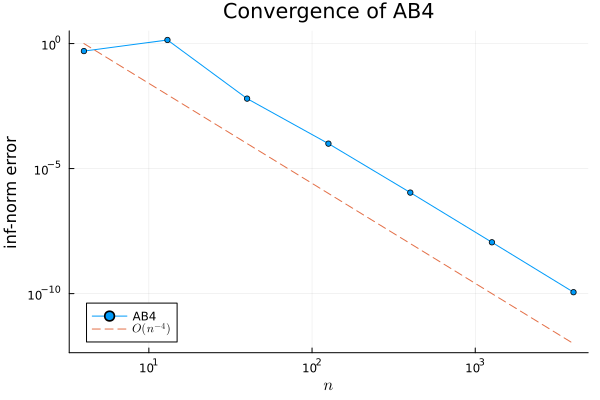

In [10]:
plot(n,err,m=3,label="AB4",
    xaxis=(:log10,L"n"),yaxis=(:log10,"inf-norm error"),
    title="Convergence of AB4",leg=:bottomleft)

plot!(n,(n/n[1]).^(-4),l=:dash,label=L"O(n^{-4})")